## Ablation Analysis

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import tqdm

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import create_random_mask
import sklearn
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
tardis.config = tardis.config_server

In [3]:
torch.cuda.is_available()

False

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [9]:
ablation_adata_path = os.path.join(tardis.config.io_directories['processed'], "figures", "ablation_afriat.h5ad")
ablation_data_path = os.path.join(tardis.config.io_directories['processed'], "figures",  "ablation_afriat.pickle")

In [10]:
# Load the data from the pickle file
with open(ablation_data_path, 'rb') as file:
    data_loaded = pickle.load(file)

# Access your data
n_leiden_df = data_loaded['n_leiden_df']
latent_dict = data_loaded['latent_dict']
reconst_r2_all = data_loaded['reconst_r2_all']
reconst_r2_valid = data_loaded['reconst_r2_valid']
mi_normalized = data_loaded['mi_normalized']
max_mig_all = data_loaded['max_mig_all']
max_mig_valid = data_loaded['max_mig_valid']

adata = ad.read_h5ad(ablation_adata_path)

In [11]:
max_mig_valid

{0.0: 0.8583398435464723,
 0.2: 0.8498139935860906,
 0.6: 0.8390569163689028,
 0.9: 0.8536651073367322,
 0.91: 0.8005857232435979,
 0.92: 0.7998108600082091,
 0.93: 0.7278903485794062,
 0.94: 0.7965884198621568,
 0.95: 0.7677562659089862,
 0.96: 0.7289297208127635,
 0.97: 0.695863051739165,
 0.98: 0.6889120654304497,
 0.99: 0.62304472593715,
 0.991: 0.6164963314790368,
 0.992: 0.6308791476009019,
 0.993: 0.5539782041046606,
 0.994: 0.5662678476950419,
 0.995: 0.5611277066047181,
 0.996: 0.5088215017204463,
 0.997: 0.5178541940242761,
 0.998: 0.5235989288170603,
 0.999: 0.3937080452082959}

In [12]:
max_mig_all

{0.0: 0.908557255181934,
 0.2: 0.9026229209533256,
 0.6: 0.8909508721397928,
 0.9: 0.898558515846128,
 0.91: 0.8558403980692696,
 0.92: 0.8477106435416616,
 0.93: 0.7717656384736541,
 0.94: 0.8480616293944564,
 0.95: 0.8170103493875503,
 0.96: 0.7708524528132553,
 0.97: 0.7453189239541848,
 0.98: 0.7252042964996579,
 0.99: 0.6620046095022633,
 0.991: 0.654052862334381,
 0.992: 0.6606043094464399,
 0.993: 0.5772475226138513,
 0.994: 0.5997191904572073,
 0.995: 0.5854947180466229,
 0.996: 0.5274677458893393,
 0.997: 0.5323170446894383,
 0.998: 0.5443981107248569,
 0.999: 0.401886749090961}

In [13]:
n_leiden_df

,target,ratio_ablation,resolution,n_leiden,random_state
0,status_control,0.0,0.025,3,10
1,status_control,0.0,0.025,3,20
2,status_control,0.0,0.025,3,30
3,status_control,0.0,0.050,3,10
4,status_control,0.0,0.050,3,20
...,...,...,...,...,...
15835,zone,0.999,1.975,447,20
15836,zone,0.999,1.975,451,30
15837,zone,0.999,2.000,448,10
15838,zone,0.999,2.000,448,20


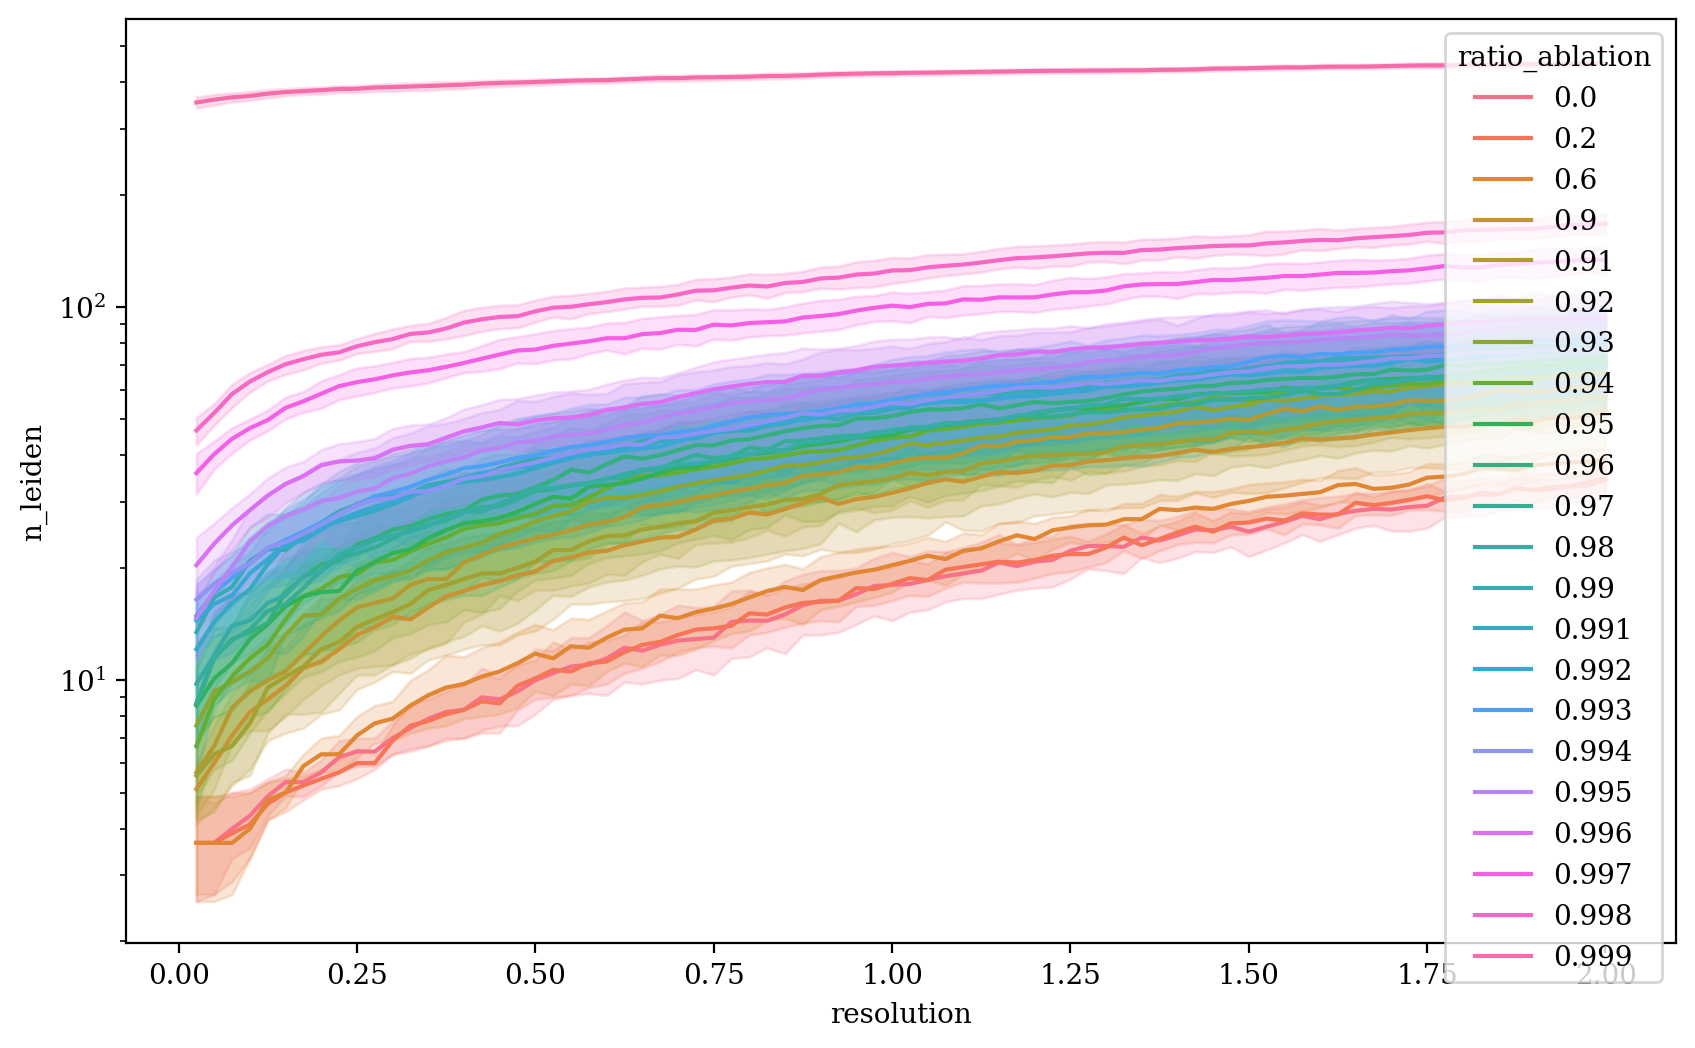

In [16]:
plt.figure(figsize=(10,6))
sns.lineplot(data=n_leiden_df, hue="ratio_ablation", y="n_leiden", x="resolution")
plt.yscale("log")

In [ ]:
# a metric to calculate the number of clusters e.g. it should be 3 in sample status etc.
# aws? knn etc?